# EDA of NSRDB solar radiation data

In [93]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import sys
import re
import math

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

# 1. Data set from weather stations

## Exam the meta data 
* https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/documentation/NSRDB_StationsMeta.csv

In [47]:
stations = pd.read_csv("NSRDB_StationsMeta.csv")
stations.head()

,USAF,CLASS,SOLAR,STATION,ST,NSRDB_LAT (dd),NSRDB_LON(dd),NSRDB_ELEV (m),TIME ZONE,ISH_LAT (dd),ISH_LON(dd),ISH_ELEV (m),20070316
0,690140,3,0,EL TORO MCAS,CA,33.667,-117.733,116,-8,33.667,-117.733,116,NaN
1,690150,2,0,TWENTYNINE PALMS,CA,34.300,-116.167,626,-8,34.300,-116.167,626,NaN
2,690160,3,0,TUSTIN MCAF,CA,33.700,-117.833,18,-8,33.700,-117.833,18,NaN
3,690190,2,0,ABILENE DYESS AFB,TX,32.433,-99.850,545,-6,32.433,-99.850,545,NaN
4,690230,2,0,WHIDBEY ISLAND NAS,WA,48.350,-122.667,10,-8,48.350,-122.667,10,NaN


In [51]:
stations_CA = stations[stations['ST'] == 'CA' ]
stations_CA.columns

Index([u'USAF', u'CLASS', u'SOLAR', u'STATION', u'ST', u'NSRDB_LAT (dd)',
       u'NSRDB_LON(dd)', u'NSRDB_ELEV (m)', u'TIME ZONE', u'ISH_LAT (dd)',
       u'ISH_LON(dd)', u'ISH_ELEV (m)', u'20070316'],
      dtype='object')

In [52]:
stations_CA = stations_CA.rename({'NSRDB_LAT (dd)':'lat', 'NSRDB_LON(dd)':'long'}, axis=1)
stations_CA.drop(['ISH_LAT (dd)', 'ISH_LON(dd)', '20070316'], axis = 1, inplace=True)

In [53]:
stations_CA = stations_CA.reset_index()
stations_CA.head()

,index,USAF,CLASS,SOLAR,STATION,ST,lat,long,NSRDB_ELEV (m),TIME ZONE,ISH_ELEV (m)
0,0,690140,3,0,EL TORO MCAS,CA,33.667,-117.733,116,-8,116
1,1,690150,2,0,TWENTYNINE PALMS,CA,34.300,-116.167,626,-8,626
2,2,690160,3,0,TUSTIN MCAF,CA,33.700,-117.833,18,-8,18
3,363,722810,3,0,NAF,CA,32.817,-115.683,-13,-8,-13
4,364,722860,2,0,MARCH AFB,CA,33.900,-117.250,462,-8,462


In [29]:
print stations_CA.shape
stations_CA.to_csv('NSRDB_CA_StationsMeta.csv')

(105, 11)


### Generate curl commands for all California stations data

In [33]:
file_list = list(stations_CA['USAF'])

In [68]:
get_files = ['curl https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/' + str(i) + '.tar.gz' + \
             ' -o ' + str(i) + '.tar.gz -s' \
             for i in file_list]
get_files[:5]

['curl https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/690140.tar.gz -o 690140.tar.gz -s',
 'curl https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/690150.tar.gz -o 690150.tar.gz -s',
 'curl https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/690160.tar.gz -o 690160.tar.gz -s',
 'curl https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/722810.tar.gz -o 722810.tar.gz -s',
 'curl https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/722860.tar.gz -o 722860.tar.gz -s']

### Download tar files Example

### download SFO airport station data

In [85]:
!curl https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/724940.tar.gz -o 724940.tar.gz -s

### To download All stations

In [67]:
import os

for i in get_files:
    os.system(i)

## Exam 1 series from station 690140

In [120]:
data_724940 = pd.read_csv('nsrdb_solar/724940/724940_2005.csv')
print data_724940.shape
data_724940.head()

(8760, 26)


,YYYY-MM-DD,HH:MM (LST),Zenith (deg),Azimuth (deg),ETR (W/m^2),ETRN (W/m^2),Glo Mod (W/m^2),Glo Mod Unc (%),Glo Mod Source,Dir Mod (W/m^2),...,Meas Glo Flg,Meas Dir (W/m^2),Meas Dir Flg,Meas Dif (W/m^2),Meas Dif Flg,TotCC (10ths),Precip Wat (cm),Precip Wat Flg,AOD (unitless),AOD Flg
0,2005-01-01,1:00,99.0,-99.0,0,0,0,0,2,0,...,99,-9900,99,-9900,99,8,1.2,51,0.108,1
1,2005-01-01,2:00,99.0,-99.0,0,0,0,0,2,0,...,99,-9900,99,-9900,99,8,1.2,3,0.108,1
2,2005-01-01,3:00,99.0,-99.0,0,0,0,0,2,0,...,99,-9900,99,-9900,99,8,1.2,3,0.108,1
3,2005-01-01,4:00,99.0,-99.0,0,0,0,0,2,0,...,99,-9900,99,-9900,99,8,1.3,3,0.108,1
4,2005-01-01,5:00,99.0,-99.0,0,0,0,0,2,0,...,99,-9900,99,-9900,99,5,1.3,3,0.108,1


In [121]:
data_724940.loc[0, :]

YYYY-MM-DD          2005-01-01
HH:MM (LST)               1:00
Zenith (deg)                99
Azimuth (deg)              -99
ETR (W/m^2)                  0
ETRN (W/m^2)                 0
Glo Mod (W/m^2)              0
Glo Mod Unc (%)              0
Glo Mod Source               2
Dir Mod (W/m^2)              0
Dir Mod Unc (%)              0
Dir Mod Source               2
Dif Mod  (W/m^2)             0
Dif Mod Unc (%)              0
Dif Mod Source               2
Meas Glo (W/m^2)         -9900
Meas Glo Flg                99
Meas Dir (W/m^2)         -9900
Meas Dir Flg                99
Meas Dif (W/m^2)         -9900
Meas Dif Flg                99
TotCC (10ths)                8
Precip Wat (cm)            1.2
Precip Wat Flg              51
AOD (unitless)           0.108
AOD Flg                      1
Name: 0, dtype: object

### Only need Dir Mod, Dif Mod, Zenith Columns

* Note: Unsure about Meas Dir and Meas Dif columns

In [122]:
data_724940 = data_724940.loc[:, ['YYYY-MM-DD', 'HH:MM (LST)', 'Zenith (deg)', 'Dir Mod (W/m^2)', \
                                  'Dif Mod  (W/m^2)', 'Meas Dir (W/m^2)', 'Meas Dif (W/m^2)']]
data_724940.head()

,YYYY-MM-DD,HH:MM (LST),Zenith (deg),Dir Mod (W/m^2),Dif Mod (W/m^2),Meas Dir (W/m^2),Meas Dif (W/m^2)
0,2005-01-01,1:00,99.0,0,0,-9900,-9900
1,2005-01-01,2:00,99.0,0,0,-9900,-9900
2,2005-01-01,3:00,99.0,0,0,-9900,-9900
3,2005-01-01,4:00,99.0,0,0,-9900,-9900
4,2005-01-01,5:00,99.0,0,0,-9900,-9900


### Change Zenith from degree to radian

In [123]:
data_724940['Zenith (deg)'] = data_724940['Zenith (deg)'].apply(math.radians)
data_724940 = data_724940.rename({'Zenith (deg)': 'Zenith (rad)'}, axis = 1)
data_724940.head()

,YYYY-MM-DD,HH:MM (LST),Zenith (rad),Dir Mod (W/m^2),Dif Mod (W/m^2),Meas Dir (W/m^2),Meas Dif (W/m^2)
0,2005-01-01,1:00,1.727876,0,0,-9900,-9900
1,2005-01-01,2:00,1.727876,0,0,-9900,-9900
2,2005-01-01,3:00,1.727876,0,0,-9900,-9900
3,2005-01-01,4:00,1.727876,0,0,-9900,-9900
4,2005-01-01,5:00,1.727876,0,0,-9900,-9900


### Galculate GHI (Global Horizontal Irradiance)

* GHI = DHI (Diffused Horizontal Irradiance) + DNI (Direct Normal Irradiance) * $cos (\theta)$
* $\theta$ = Solar Zenith Angle

Transform GHI to SPI (Solar Potential Index)
* Annual or Monthly Average GHI / Max Potential GHI
* Index range from 0 to 1

Solar Generation (kilowatt - kW) = $SPI \times Installed capacity$


In [125]:
data_724940['GHI'] = data_724940['Dif Mod  (W/m^2)'].astype('float') + \
        data_724940['Dir Mod (W/m^2)']. astype('float') * data_724940['Zenith (rad)'].apply(math.cos)
data_724940.head()

,YYYY-MM-DD,HH:MM (LST),Zenith (rad),Dir Mod (W/m^2),Dif Mod (W/m^2),Meas Dir (W/m^2),Meas Dif (W/m^2),GHI
0,2005-01-01,1:00,1.727876,0,0,-9900,-9900,0.0
1,2005-01-01,2:00,1.727876,0,0,-9900,-9900,0.0
2,2005-01-01,3:00,1.727876,0,0,-9900,-9900,0.0
3,2005-01-01,4:00,1.727876,0,0,-9900,-9900,0.0
4,2005-01-01,5:00,1.727876,0,0,-9900,-9900,0.0


### Plot 1 day series of GHI

In [149]:
data_724940_1day = data_724940[data_724940['YYYY-MM-DD'] == '2005-07-01']
data_724940_1day = data_724940_1day.reset_index()

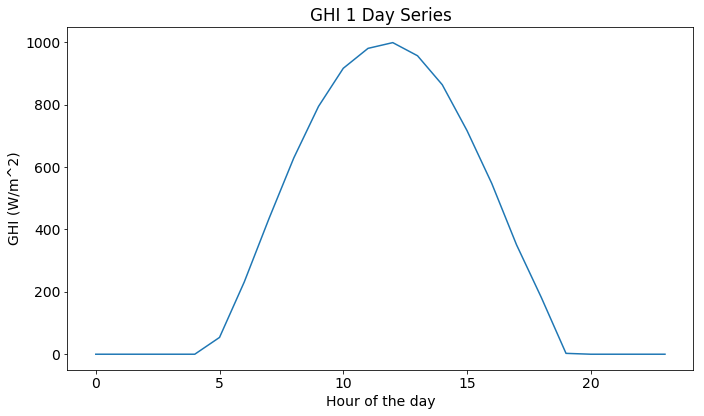

In [308]:
fig, ax = plt.subplots(figsize=(10,6));

data_724940_1day['GHI'].plot(ax=ax);
matplotlib.rc('font', size=14)
ax.set_title('GHI 1 Day Series');
ax.set_ylabel('GHI (W/m^2)');
ax.set_xlabel('Hour of the day');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

### Plot 1 Year of daily series using average GHI / Day

In [153]:
data_724940['YYYY-MM-DD'] = pd.to_datetime(data_724940['YYYY-MM-DD'])

In [154]:
data_724940.head()

,YYYY-MM-DD,HH:MM (LST),Zenith (rad),Dir Mod (W/m^2),Dif Mod (W/m^2),Meas Dir (W/m^2),Meas Dif (W/m^2),GHI
0,2005-01-01,1:00,1.727876,0,0,-9900,-9900,0.0
1,2005-01-01,2:00,1.727876,0,0,-9900,-9900,0.0
2,2005-01-01,3:00,1.727876,0,0,-9900,-9900,0.0
3,2005-01-01,4:00,1.727876,0,0,-9900,-9900,0.0
4,2005-01-01,5:00,1.727876,0,0,-9900,-9900,0.0


In [155]:
daily = data_724940.groupby('YYYY-MM-DD')

In [197]:
daily_avg_GHI = daily['YYYY-MM-DD', 'GHI'].max()
daily_avg_GHI.head()

,YYYY-MM-DD,GHI
YYYY-MM-DD,,
2005-01-01,2005-01-01,385.062038
2005-01-02,2005-01-02,101.000000
2005-01-03,2005-01-03,328.908157
2005-01-04,2005-01-04,427.972262
2005-01-05,2005-01-05,157.000000


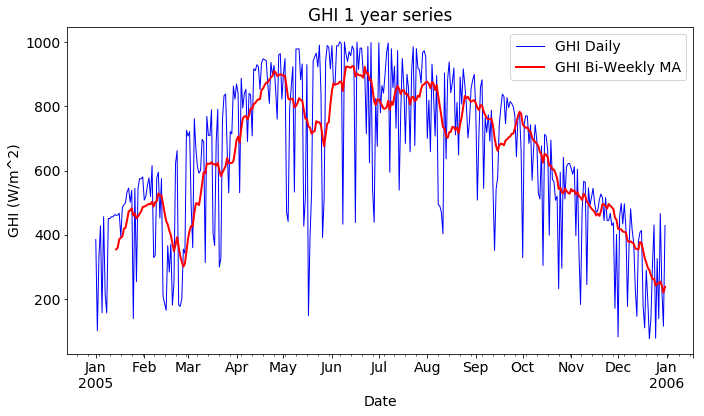

In [309]:
fig, ax = plt.subplots(figsize=(10,6));

daily_avg_GHI['GHI'].plot(ax=ax, color = 'b', linewidth = 1);
daily_avg_GHI['GHI'].rolling(window=14).mean().plot(ax=ax, color='r', linewidth = 2);
matplotlib.rc('font', size=14)
ax.set_title('GHI 1 year series');
ax.set_ylabel('GHI (W/m^2)');
ax.set_xlabel('Date');
ax.legend(['GHI Daily', 'GHI Bi-Weekly MA']);
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

### Create helper function to steamline preprocessing

In [203]:
# To preprocess the data frame and caculate the GHI
def preprocess(df):
    # Select columns
    df = df.loc[:, ['YYYY-MM-DD', 'HH:MM (LST)', 'Zenith (deg)', 'Dir Mod (W/m^2)', \
                    'Dif Mod  (W/m^2)', 'Meas Dir (W/m^2)', 'Meas Dif (W/m^2)']]
    
    # Convert degree to radian
    df['Zenith (deg)'] = df['Zenith (deg)'].apply(math.radians)
    df = df.rename({'Zenith (deg)': 'Zenith (rad)'}, axis = 1)
    
    # Calculate GHI
    df['GHI'] = df['Dif Mod  (W/m^2)'].astype('float') + \
                df['Dir Mod (W/m^2)']. astype('float') * df['Zenith (rad)'].apply(math.cos)
    
    # Convert str to date and time
    df['YYYY-MM-DD'] = pd.to_datetime(df['YYYY-MM-DD'])  
    return df

# Create daily aggregated GHI time series (from hourly data)
# Agg_method: 'mean', 'max', 'sum'
def ts_GHI(df, agg_method):
    daily = df.groupby('YYYY-MM-DD')
    if agg_method == 'mean':
        daily_GHI = daily['YYYY-MM-DD', 'GHI'].mean()
    elif agg_method == 'max': 
        daily_GHI = daily['GHI'].max()
        daily_GHI = daily_GHI.drop('YYYY-MM-DD', axis=1)
    elif agg_method == 'sum': 
        daily_GHI = daily['YYYY-MM-DD', 'GHI'].sum()      
    return daily_GHI

## Compare 3 yearly series

In [189]:
data_724940_2005 = pd.read_csv('nsrdb_solar/724940/724940_2005.csv')
data_724940_2004 = pd.read_csv('nsrdb_solar/724940/724940_2004.csv')
data_724940_2003 = pd.read_csv('nsrdb_solar/724940/724940_2003.csv')

In [204]:
daily_ts_2005 = ts_GHI(preprocess(data_724940_2005), 'mean')
daily_ts_2005.head()

,GHI
YYYY-MM-DD,
2005-01-01,64.825892
2005-01-02,25.083333
2005-01-03,63.514497
2005-01-04,78.135789
2005-01-05,32.273162


In [205]:
daily_ts_2004 = ts_GHI(preprocess(data_724940_2004), 'mean')
daily_ts_2004.head()

,GHI
YYYY-MM-DD,
2004-01-01,21.916667
2004-01-02,47.889476
2004-01-03,106.720067
2004-01-04,108.623352
2004-01-05,102.743860


In [206]:
daily_ts_2003 = ts_GHI(preprocess(data_724940_2003), 'mean')
daily_ts_2003.head()

,GHI
YYYY-MM-DD,
2003-01-01,95.492742
2003-01-02,49.728005
2003-01-03,88.470173
2003-01-04,90.690566
2003-01-05,105.707044


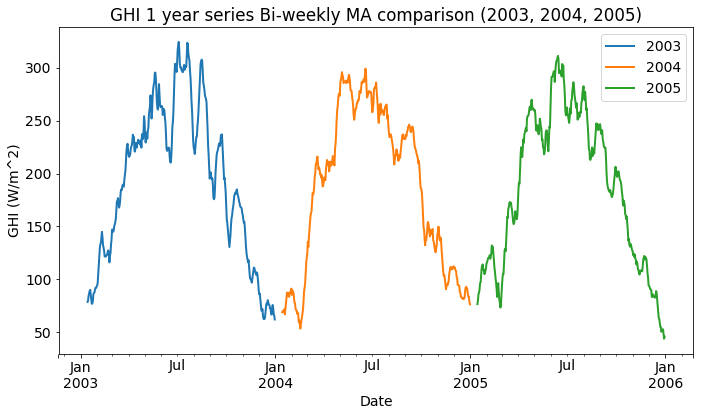

In [310]:
fig, ax = plt.subplots(figsize=(10,6));

daily_ts_2003['GHI'].rolling(window=14).mean().plot(ax=ax, linewidth = 2);
daily_ts_2004['GHI'].rolling(window=14).mean().plot(ax=ax, linewidth = 2);
daily_ts_2005['GHI'].rolling(window=14).mean().plot(ax=ax, linewidth = 2);
matplotlib.rc('font', size=14)
ax.set_title('GHI 1 year series Bi-weekly MA comparison (2003, 2004, 2005)');
ax.set_ylabel('GHI (W/m^2)');
ax.set_xlabel('Date');
ax.legend(['2003', '2004', '2005']);
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

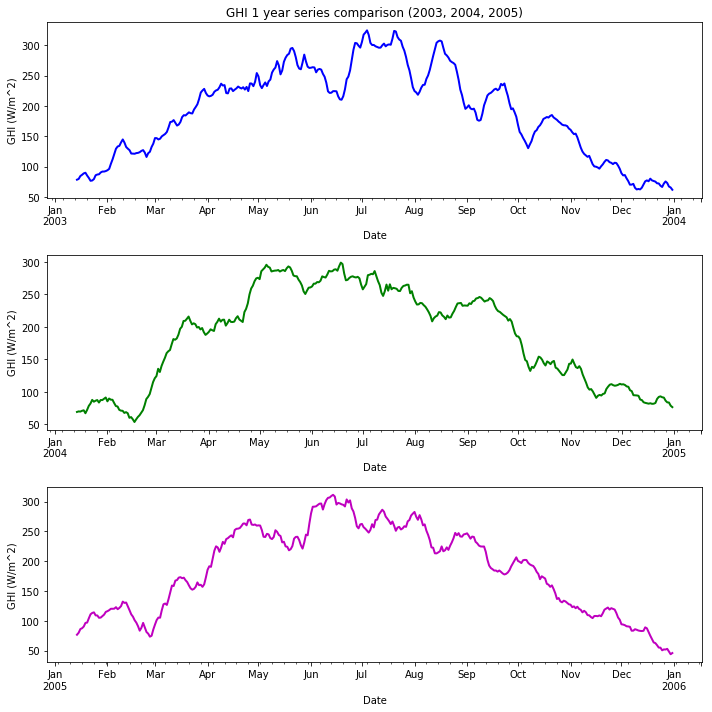

In [229]:
plt.figure(figsize=(10,10))
layout = (3, 1)
ax1 = plt.subplot2grid(layout, (0, 0))
ax2 = plt.subplot2grid(layout, (1, 0))
ax3 = plt.subplot2grid(layout, (2, 0))

daily_ts_2003['GHI'].rolling(window=14).mean().plot(ax = ax1, color = 'b', linewidth = 2);
daily_ts_2004['GHI'].rolling(window=14).mean().plot(ax = ax2, color = 'g', linewidth = 2);
daily_ts_2005['GHI'].rolling(window=14).mean().plot(ax = ax3, color = 'm', linewidth = 2);

matplotlib.rc('font', size=14)
ax1.set_title('GHI 1 year series comparison (2003, 2004, 2005)');
ax1.set_ylabel('GHI (W/m^2)');
ax1.set_xlabel('Date');
ax1.xaxis.set_ticks_position('bottom')
ax2.set_ylabel('GHI (W/m^2)');
ax2.set_xlabel('Date');
ax2.xaxis.set_ticks_position('bottom')
ax3.set_ylabel('GHI (W/m^2)');
ax3.set_xlabel('Date');
ax3.xaxis.set_ticks_position('bottom')

plt.tight_layout()

## Exam Seasonality

#### read all csv of station 724940

In [230]:
!ls nsrdb_solar/724940/

724940_1991.csv 724940_1994.csv 724940_1997.csv 724940_2000.csv 724940_2003.csv
724940_1992.csv 724940_1995.csv 724940_1998.csv 724940_2001.csv 724940_2004.csv
724940_1993.csv 724940_1996.csv 724940_1999.csv 724940_2002.csv 724940_2005.csv


In [238]:
import glob
allFiles = glob.glob('nsrdb_solar/724940/*.csv')
data_724940_all = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
data_724940_all = pd.concat(list_)

In [281]:
data_724940_all.head()

,YYYY-MM-DD,HH:MM (LST),Zenith (deg),Azimuth (deg),ETR (W/m^2),ETRN (W/m^2),Glo Mod (W/m^2),Glo Mod Unc (%),Glo Mod Source,Dir Mod (W/m^2),...,Meas Glo Flg,Meas Dir (W/m^2),Meas Dir Flg,Meas Dif (W/m^2),Meas Dif Flg,TotCC (10ths),Precip Wat (cm),Precip Wat Flg,AOD (unitless),AOD Flg
0,1991-01-01,1:00,99.0,-99.0,0,0,0,0,1,0,...,99,-9900,99,-9900,99,6,0.7,1,0.108,1
1,1991-01-01,2:00,99.0,-99.0,0,0,0,0,1,0,...,99,-9900,99,-9900,99,10,0.7,1,0.108,1
2,1991-01-01,3:00,99.0,-99.0,0,0,0,0,1,0,...,99,-9900,99,-9900,99,10,0.8,1,0.108,1
3,1991-01-01,4:00,99.0,-99.0,0,0,0,0,1,0,...,99,-9900,99,-9900,99,10,0.8,1,0.108,1
4,1991-01-01,5:00,99.0,-99.0,0,0,0,0,1,0,...,99,-9900,99,-9900,99,10,0.8,1,0.108,1


In [282]:
daily_ts_724940 = ts_GHI(preprocess(data_724940_all), 'mean')
daily_ts_724940.head()

,GHI
YYYY-MM-DD,
1991-01-01,95.999216
1991-01-02,79.882632
1991-01-03,66.103866
1991-01-04,104.289976
1991-01-05,92.727031


In [283]:
monthly_ts_724940 = daily_ts_724940.resample('MS').mean()
monthly_ts_724940.head()

,GHI
YYYY-MM-DD,
1991-01-01,97.920526
1991-02-01,124.346861
1991-03-01,153.352904
1991-04-01,243.900563
1991-05-01,270.734378


In [284]:
monthly_ts_724940['Month'] = monthly_ts_724940.index.strftime('%b')
monthly_ts_724940['Year'] = monthly_ts_724940.index.year
monthly_ts_724940.head()

,GHI,Month,Year
YYYY-MM-DD,,,
1991-01-01,97.920526,Jan,1991
1991-02-01,124.346861,Feb,1991
1991-03-01,153.352904,Mar,1991
1991-04-01,243.900563,Apr,1991
1991-05-01,270.734378,May,1991


In [287]:
monthly_ts_724940_piv = monthly_ts_724940.pivot(index='Year', columns='Month', values='GHI')
monthly_ts_724940_piv.head()

Month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Year,,,,,,,,,,,,
1991,243.900563,216.012224,83.966056,124.346861,97.920526,299.547207,281.222369,153.352904,270.734378,115.132984,168.221224,219.605968
1992,232.528880,267.670241,78.234726,112.523604,94.638537,298.855718,290.469419,156.820973,294.886707,110.547064,154.084326,225.826770
1993,244.986438,259.140815,83.973562,108.705803,81.146011,322.733104,314.552270,163.053668,254.947767,115.109582,140.584619,222.120282
1994,229.689655,290.204103,83.906807,117.937871,101.277616,306.831300,329.522337,183.775364,262.760135,102.982632,171.340706,227.870778
1995,221.317172,296.242751,71.406947,115.772610,63.464431,304.365846,296.288553,157.175102,254.192081,112.980281,172.288250,225.518820


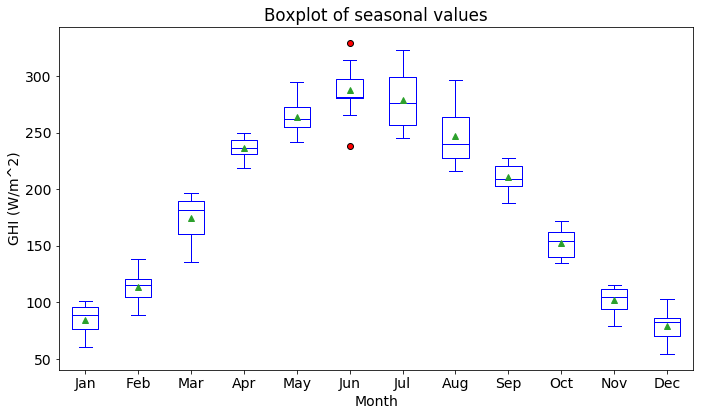

In [307]:
# put the months in order
month_names = pd.date_range(start='2017-01-01', periods=12, freq='MS').strftime('%b')
monthly_ts_724940_piv = monthly_ts_724940_piv.reindex(columns=month_names)

# plot
fig, ax = plt.subplots(figsize=(10, 6))
monthly_ts_724940_piv.plot(ax=ax, kind='box', color = 'b', showmeans=True, 
                           boxprops=dict(linewidth = 1), medianprops = dict(linewidth=1),
                           flierprops = dict(markerfacecolor='r'));

matplotlib.rc('font', size=14)
ax.set_xlabel('Month');
ax.set_ylabel('GHI (W/m^2)');
ax.set_title('Boxplot of seasonal values');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();